In this tutorial, let us verify the computed CNID. 

We do this by sampling the total energy of a system of Si(111)/SiC(0001) interface with 
displacing one crystal in the CNID.

# Again, making an two-D CSL interface following the previous tutorials

In [1]:
from interfacemaster.cellcalc import get_primitive_hkl, get_pri_vec_inplane, get_normal_index
from interfacemaster.interface_generator import core, print_near_axis, convert_vector_index, write_trans_file
from numpy import array, dot, round, cross
from numpy.linalg import inv, det

In [2]:
my_interface = core('cif_files/Si_mp-149_conventional_standard.cif',\
                    'cif_files/SiC_mp-568656_conventional_standard.cif')

Warning!, this programme will rewrite the POSCAR file in this dir!


/Users/jasonxie/.local/lib/python3.8/site-packages/pymatgen/io/cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [22]:
hkl_1 = get_primitive_hkl([1,1,1], my_interface.conv_lattice_1, my_interface.lattice_1)
hkl_2 = get_primitive_hkl([0,0,1], my_interface.conv_lattice_2, my_interface.lattice_2)

In [120]:
my_interface.parse_limit(du = 2e-2, S  = 2e-2, sgm1=50, sgm2=50, dd = 2e-2)

#Do searching!
my_interface.search_one_position_2D(hkl_1, hkl_2, theta_range = 180, \
                                    dtheta = 0.01, start = 15)

2
[1.367182 1.367182 1.367182] [0. 0. 1.]
[-0.57735027 -0.57735027 -0.57735027] [ 0.  0. -1.]
Congrates, we found an appx CSL!

U1 = 
[[ 1 -6]
 [-6  5]
 [ 5  1]]; sigma_1 = 54

U2 = 
[[-3 -5]
 [-8  3]
 [ 0  0]]; sigma_2 = 49

D = 
[[ 0.99590432  0.00730638 -0.0032107 ]
 [-0.0032107   0.99590432  0.00730638]
 [ 0.00730638 -0.0032107   0.99590432]]

axis = [-7.47674648 -7.47674648 -7.47674648] ; theta = 15.21



In [121]:
my_interface.compute_bicrystal_two_D(hkl_1 = hkl_1, hkl_2=hkl_2, \
                                     normal_ortho = True, plane_ortho = True, \
                                     lim = 50, tol = 1e-2)
my_interface.get_bicrystal(two_D = True, xyz_1 = [2,1,1], xyz_2 = [2,1,1])

[[ 13.67182    2.734364]
 [-16.406184  13.67182 ]
 [  2.734364 -16.406184]]
[[ 13.67182    2.734364]
 [-16.406184  13.67182 ]
 [  2.734364 -16.406184]]
[[ 1.89442295e+01 -7.41964412e-16  1.24257699e-15]
 [ 5.02782966e-16  2.15304037e+01 -1.07652018e+01]
 [-5.56650364e-16  9.20825833e-16  1.86458765e+01]]


# Generate LAMMPS commands to sampling system energy in the CNID

The interface structure can be complex, especially when we can have a 'triclinic' cell.

Therefore, we provide some functions here to help you write some necessary input commands for LAMMPS.

Note that it is far more effective to do looping by LAMMPS's looping variables than by generating many different atom files!

1. Define regions & groups

In [86]:
my_interface.CNID

array([[-5.58105020e-17,  5.58105020e-17],
       [ 4.61435630e-16, -2.73436400e+00],
       [ 1.82290933e+00,  9.11454667e-01]])

In [111]:
my_interface.define_lammps_regions(['right'],[5.2],[10.5])

You can see that here we generated a 'blockfile' file defining a
'right' group, which will be displaced during the simulation.

2. Define translation variables

To verify the periodicity of CNID, we translate in a 2x2 expansion of CNID divided into a fine 50x50 grids 
(dont worry, this won't take a long time :D)

In [112]:
v1, v2 = 2*dot(my_interface.orient, my_interface.CNID).T
write_trans_file(v1,v2,100,100)

Here we generated a 'paras' file, including the looping variables and 
the translation variables which will be applied in the 'displace_atoms' command.

Now, put these two files in the 'CNID_check' folder and run LAMMPS in this folder!

# Visualize the energy distribution in the CNID

Copy the 'results' file into the working folder here and lets have a look at the energy distribution of our system energy with displacing the 'right' crystal in the CNID

In [89]:
from numpy import *

In [113]:
dx, dy, dz, energy = loadtxt('results', unpack = True)

<ipython-input-118-8f760efb8a4b>:4: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(pcm,cmap = 'hot')


(-5.684742756, 0.2707020360000009, -5.684742756, 0.27070203600000003)

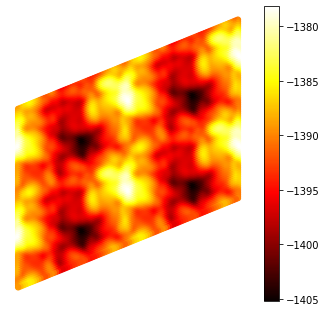

In [118]:
import matplotlib.pyplot as plt
plt.figure(figsize = ((max(dy) - min(dy)),(max(dz) - min(dz))))
pcm = plt.scatter(dy,dz, c = energy,cmap = 'hot',s=30)
plt.colorbar(pcm,cmap = 'hot')

#since dx is almost zero (interface is in the y-z plane), we just check dz & dy
#plt.ylabel('dz',fontsize = 20)
#plt.xlabel('dy',fontsize = 20)
plt.axis('off')
#plt.savefig('100_0001',dpi=600)

In [51]:
import cnidcal.cnidcal as cdc
import numpy as np
from numpy import dot, cross, pi, square, array
from numpy.linalg import det, norm, inv
from cnidcal.celldraw import cellsdrawer

In [102]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=16)
with open('Si(100)_SiC(0001)', 'w') as f:
    f.write('lattice_1 = ' + str(my_interface.lattice_1) + '\n\n')
    f.write('lattice_2 = ' + str(my_interface.lattice_2) + '\n\n')
    f.write('R = ' + str(my_interface.R) + '\n\n')
    f.write('D = ' + str(my_interface.D) + '\n\n')

IsADirectoryError: [Errno 21] Is a directory: 'Si(100)_SiC(0001)'

In [85]:
import os

In [92]:
#os.mkdir('Si(100)_SiC(0001)')
np.save("Si(100)_SiC(0001)//lattice_1.npy",my_interface.lattice_1)
np.save("Si(100)_SiC(0001)//lattice_2.npy",my_interface.lattice_2)
np.save("Si(100)_SiC(0001)//D.npy",my_interface.D)
np.save("Si(100)_SiC(0001)//R.npy",my_interface.R)

In [71]:
my_interface.lattice_1

1.6000000000000001


In [58]:
my_interface.lattice_2

array([[-1.54732744e+00, -1.54732744e+00,  0.00000000e+00],
       [-2.68004974e+00,  2.68004974e+00,  0.00000000e+00],
       [-3.78985919e-16,  1.89492960e-16, -2.53091000e+01]])

In [69]:
print(my_interface.D)

[[ 1.03083913e+00 -2.64623635e-16 -2.65463112e-16]
 [-3.00810569e-17  9.29948556e-01 -6.01546253e-04]
 [ 1.55546047e-16  9.93828309e-02  1.00563001e+00]]


In [60]:
dot(my_interface.D, my_interface.lattice_2)

array([[-1.59504567e+00, -1.59504567e+00,  6.71863245e-15],
       [-2.49230839e+00,  2.49230839e+00,  1.52245943e-02],
       [-2.66350930e-01,  2.66350930e-01, -2.54515905e+01]])

In [61]:
my_interface.conv_lattice_1

array([[ 5.46872800e+00, -3.34863012e-16,  0.00000000e+00],
       [ 0.00000000e+00,  5.46872800e+00,  0.00000000e+00],
       [ 3.34863012e-16,  3.34863012e-16,  5.46872800e+00]])

In [62]:
my_interface.R

array([[-2.43155844e-16, -1.06264071e-01,  9.94337944e-01],
       [ 8.62919631e-18, -9.94337944e-01, -1.06264071e-01],
       [ 1.00000000e+00, -1.72583926e-17,  2.42696055e-16]])

In [63]:
dot(my_interface.lattice_1, my_interface.bicrystal_U1)

array([[-5.46872800e+00, -7.78952222e-16,  1.15543603e-17],
       [ 0.00000000e+00,  3.00780040e+01, -3.00780040e+01],
       [ 0.00000000e+00, -1.91405480e+01, -1.91405480e+01]])

In [64]:
miller_ind_pri = cdc.get_primitive_hkl(hkl = [1,0,0], C_lattice=my_interface.conv_lattice_1, P_lattice=my_interface.lattice_1)
miller_ind_pri

array([-1, -1,  0])

In [65]:
lattice_1 = my_interface.lattice_1
lattice_2 = dot(my_interface.D, my_interface.lattice_2)
PB_1, PB_2 = cdc.get_two_bases(lattice_1, lattice_2, my_interface.R, miller_ind_pri)
PB_1, PB_2

(array([[-1.67431506e-16,  0.00000000e+00],
        [ 2.73436400e+00, -2.73436400e+00],
        [ 2.73436400e+00,  2.73436400e+00]]),
 array([[ 2.56315415e-17, -3.39656039e-17],
        [ 2.50650033e+00,  2.50650033e+00],
        [-1.59504567e+00,  1.59504567e+00]]))

In [15]:
CSL = cdc.search_CSL(PB_1, PB_2, 20)
CNID = cdc.searchcnid(PB_1, PB_2, 20)

In [16]:
#CSL expressed in the primitive and conventional cell
CSL_in_P = np.round(cdc.get_coef_exp_ltc(lattice_1, CSL),5)
CSL_in_C = np.round(cdc.get_coef_exp_ltc(my_interface.conv_lattice_1, CSL),5)
CSL_in_P, CSL_in_C

(array([[ 2.,  9.],
        [-2., -9.],
        [ 9.,  2.]]),
 array([[-0. , -0. ],
        [-5.5, -5.5],
        [-3.5,  3.5]]))

In [17]:
#CNID expressed in primitive lattice 1
CNID_in_P = cdc.get_coef_exp_ltc(lattice_1, CNID)
cdc.get_fraction_basis(CNID_in_P)

array([['0/12', '1/12'],
       ['0/12', '-1/12'],
       ['1/12', '0/12']], dtype='<U21')

In [18]:
#CNID expressed in conventional lattice 1
CNID_in_C = cdc.get_coef_exp_ltc(my_interface.conv_lattice_1, CNID)
cdc.get_fraction_basis(CNID_in_C)

array([['0/24', '0/24'],
       ['-1/24', '-1/24'],
       ['-1/24', '1/24']], dtype='<U21')

In [19]:
#CNID expressed in lattice 2
CNID_in_P = cdc.get_coef_exp_ltc(dot(my_interface.R,lattice_2), CNID)
cdc.get_fraction_basis(CNID_in_P)

array([['2/77', '-9/77'],
       ['9/77', '-2/77'],
       ['0/77', '0/77']], dtype='<U21')

In [20]:
my_cells = cellsdrawer(PB_1, PB_2, CSL, CNID, 20)

In [23]:
import os
os.getcwd()

'/Users/jasonxie/Documents/GitHub/interface_master/test_files'

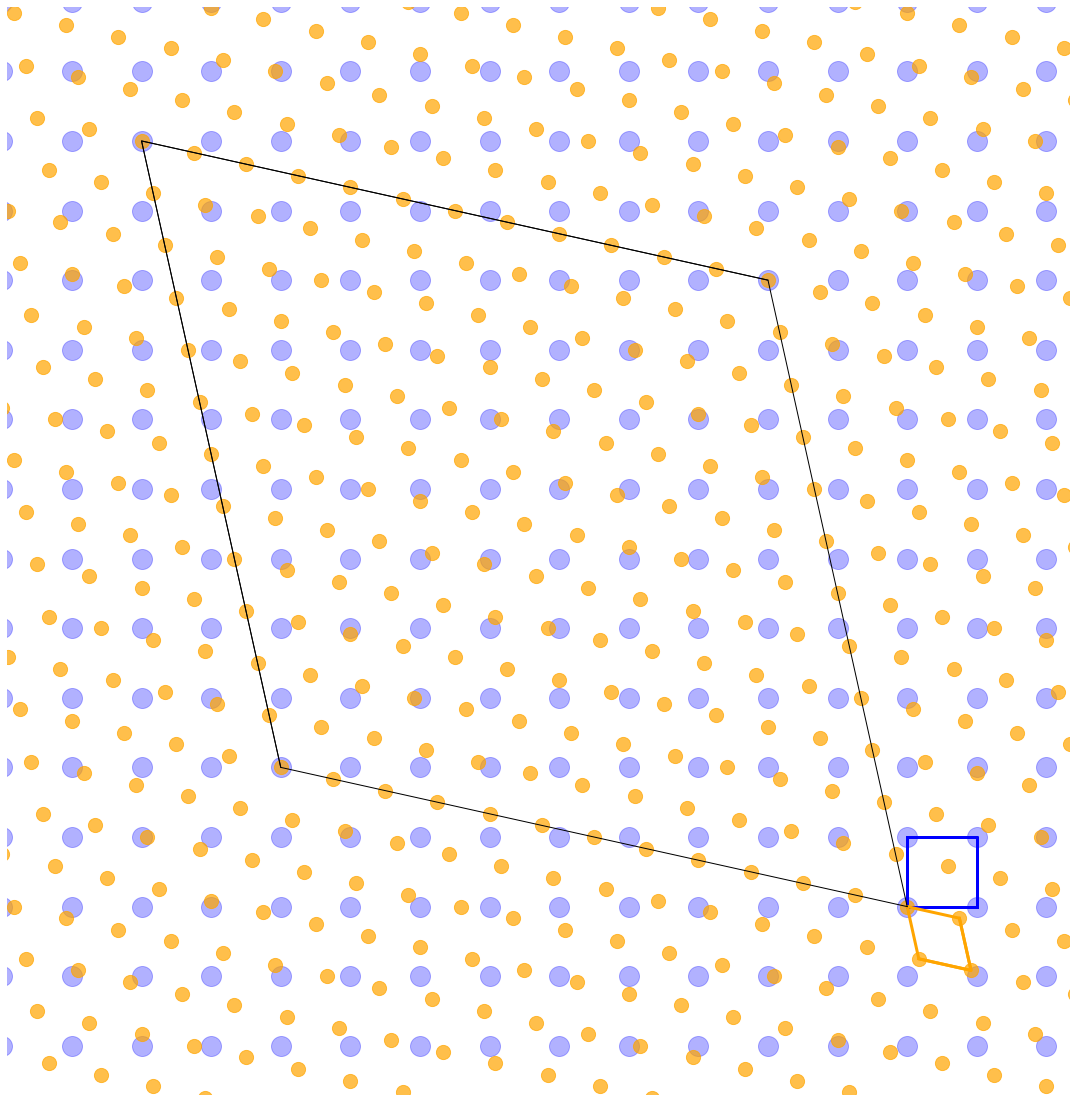

In [21]:
#Show the two lattices and their CSL
my_cells.draw_direct(xlow = -50, xhigh = 9, ylow = -10.4, 
                     yhigh = 50, figsize_x = 20, figsize_y = 20, save=True, size_LP_1=400, size_LP_2=200)

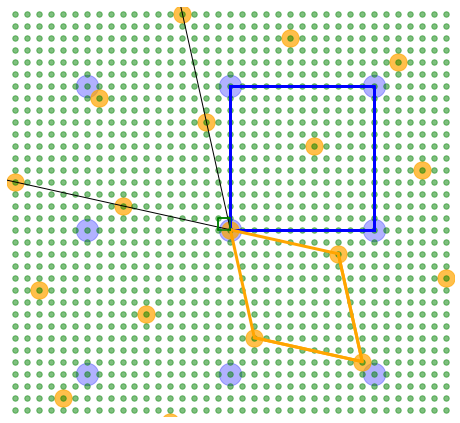

In [24]:
#Show the zoomed figure and DSC
my_cells.draw_direct(xlow = -6, xhigh = 6, ylow = -5, yhigh = 6, \
                     figsize_x = 8, figsize_y = 10, size_LP_1 = 500, \
                     size_LP_2 = 300, show_CNID_points = True, show_CNID_cell = True, save=True)

In [66]:
lattice_1 = array([[-2.73436400e+00, -2.73436400e+00,  1.67431506e-16],
                   [-2.73436400e+00,  0.00000000e+00, -2.73436400e+00],
                   [ 0.00000000e+00, -2.73436400e+00, -2.73436400e+00]])

lattice_2 = array([[-1.54732744e+00, -1.54732744e+00,  0.00000000e+00],
                   [-2.68004974e+00,  2.68004974e+00,  0.00000000e+00],
                   [-3.78985919e-16,  1.89492960e-16, -2.53091000e+01]])

D = array([[ 1.03083913e+00, -2.64623635e-16, -2.65463112e-16],
           [-3.00810569e-17,  9.29948556e-01, -6.01546253e-04],
           [ 1.55546047e-16,  9.93828309e-02,  1.00563001e+00]])

R = array([[-2.43155844e-16, -1.06264071e-01,  9.94337944e-01],
           [ 8.62919631e-18, -9.94337944e-01, -1.06264071e-01],
           [ 1.00000000e+00, -1.72583926e-17,  2.42696055e-16]])

lattice_2 = dot(D, lattice_2)

In [67]:
conv_lattice_1 = array([[ 5.46872800e+00, -3.34863012e-16,  0.00000000e+00],
                        [ 0.00000000e+00,  5.46872800e+00,  0.00000000e+00],
                        [ 3.34863012e-16,  3.34863012e-16,  5.46872800e+00]])

miller_ind_pri = cdc.get_primitive_hkl(hkl = [1,0,0], C_lattice = conv_lattice_1, P_lattice = lattice_1)
miller_ind_pri

array([-1, -1,  0])

In [68]:
PB_1, PB_2 = cdc.get_two_bases(lattice_1, lattice_2, R, miller_ind_pri)
PB_1, PB_2

RuntimeError: failed to find the rational vector of [ 1.00000000e+00 -9.99999961e-01  2.58815697e+10]
 within denominator <= 10000

The CNID was well verified by such energy distribution.
We obtained a complete pattern with 2x2 periodicity, which also illustrates the point group of the CNID!